# Individual analysis

In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# Inspired by https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d due to the nice design!

def plot_coefficients(classifier, feature_names, figurename, savePlt=False, top_features=10):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 font = {'size'   : 18}
 mpl.rc('font', **font) 
 fig, ax= plt.subplots(1, 1, figsize=(11,5)) 
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 ax.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
#  ax.set_yticks([-1, 0, 1])
 ax.set_xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=40, ha='right', rotation_mode="anchor")
 ax.set_ylabel('Feature weight')
 if savePlt:
    plt.savefig('Graphs/featureImp_' + figurename + '.pdf', format="pdf", bbox_inches="tight")
 plt.show()

## Wine

In [2]:
# Read
wine1 = pd.read_csv("Data/Wine/winemag-data-130k-v2.csv", index_col=0)
wine2 = pd.read_csv("Data/Wine/winemag-data_first150k.csv", index_col=0)
wineRevs = pd.concat([wine1, wine2])
print(wineRevs.columns)

# Rename
wineRevs = wineRevs[['description', 'points']]

# Remove duplicates 
print(wineRevs.shape)
wineRevs = wineRevs.drop_duplicates(subset=['description']).reset_index(drop=True)
print('-----')
print(wineRevs.shape)
wineRevs[1:5]

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')
(280901, 2)
-----
(169430, 2)


,description,points
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


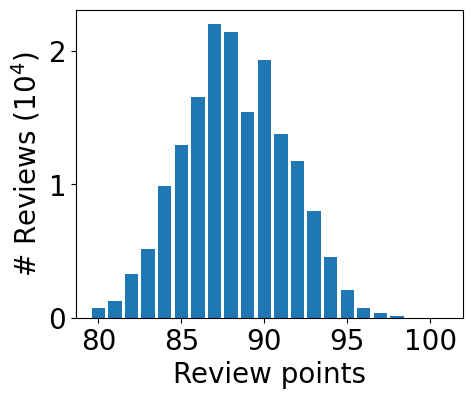

In [18]:
font = {'size'   : 20}
mpl.rc('font', **font) 
fig, ax= plt.subplots(1, 1, figsize=(5,4)) 
ax.hist(wineRevs['points'], width=0.8, bins=(np.arange(80,100)-0.4)) #adjustment for bar above number
ax.get_yaxis().get_offset_text().set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlim(right=102)
ax.set_yticks([0, 10000, 20000])
ax.set_xticks([80, 85, 90, 95, 100])
ax.set_ylabel('# Reviews' + ' ($ 10^{%d}$)' % math.log10(max(ax.get_yticks())))
ax.set_xlabel('Review points')
plt.savefig("Graphs/histPoints_wine.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [5]:
print(wineRevs['points'].value_counts().sort_index())

80       759
81      1263
82      3303
83      5157
84      9849
85     12948
86     16564
87     21994
88     21442
89     15432
90     19292
91     13801
92     11744
93      7992
94      4573
95      2053
96       745
97       331
98       120
99        42
100       26
Name: points, dtype: int64


In [3]:
nlp = spacy.load("en_core_web_lg")
description = []
for desc in wineRevs['description']:
    doc = nlp(desc) 
    description.append(' '.join([token.lemma_ for token in doc if (not token.is_stop and token.is_alpha)]))
wineRevs['description'] = description

In [12]:
df_wine = wineRevs.copy()
points = []
for row in df_wine.points:
    if row < 90:
        points.append(0)
    else:
        points.append(1)

df_wine['points'] = points

In [ ]:
print(df_wine['points'].value_counts())

0    108711
1     60719
Name: points, dtype: int64


In [13]:
train_x, test_x, train_y, test_y = train_test_split(df_wine.description, df_wine.points, train_size=0.8, random_state=50)

In [14]:
cv = CountVectorizer()
X_train = cv.fit_transform(train_x)
X_test = cv.transform(test_x)

In [ ]:
classifier_naive = MultinomialNB()
classifier_naive.fit(X_train, train_y)
prediction_naive = classifier_naive.predict(X_test)
print(classification_report(test_y, prediction_naive))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     21667
           1       0.70      0.77      0.74     12219

    accuracy                           0.80     33886
   macro avg       0.78      0.79      0.79     33886
weighted avg       0.81      0.80      0.80     33886



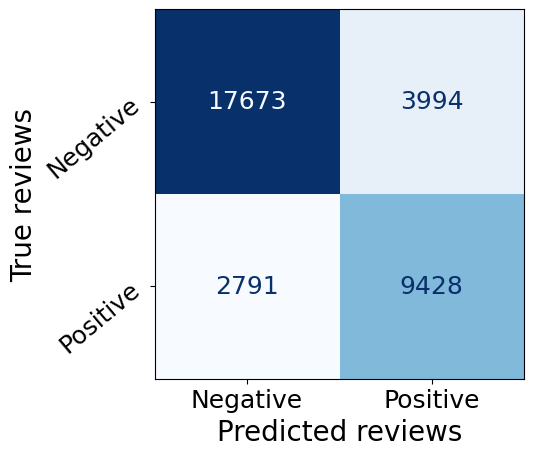

<Figure size 640x480 with 0 Axes>

In [ ]:
cm_svm = ConfusionMatrixDisplay.from_estimator(classifier_naive, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()
plt.savefig('Graphs/CM_naive_Wine.pdf', format="pdf", bbox_inches="tight")

In [15]:
svm = LinearSVC(dual=False) # dual false if samples > features
svm.fit(X_train, train_y)
prediction_svm = svm.predict(X_test)
print(classification_report(test_y, prediction_svm))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     21667
           1       0.78      0.73      0.76     12219

    accuracy                           0.83     33886
   macro avg       0.82      0.81      0.81     33886
weighted avg       0.83      0.83      0.83     33886



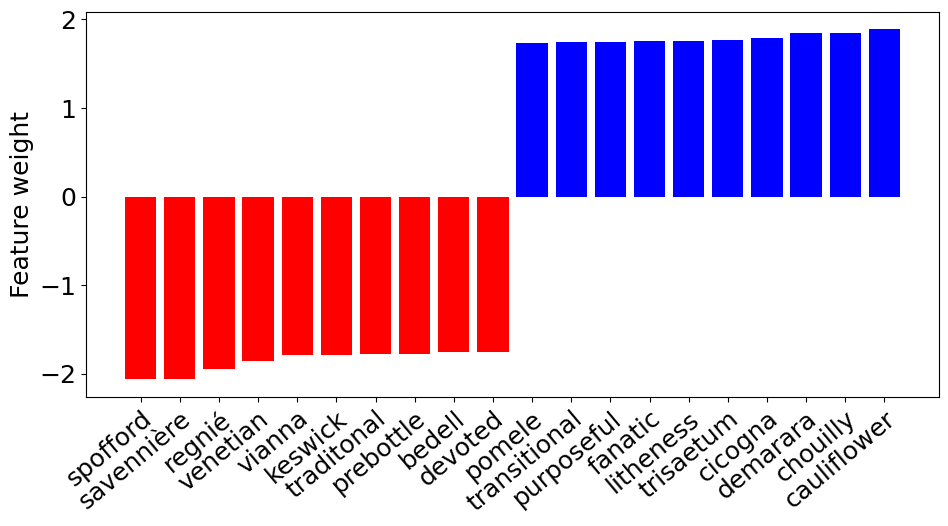

In [17]:
plot_coefficients(svm, cv.get_feature_names_out(), 'Wine', True)

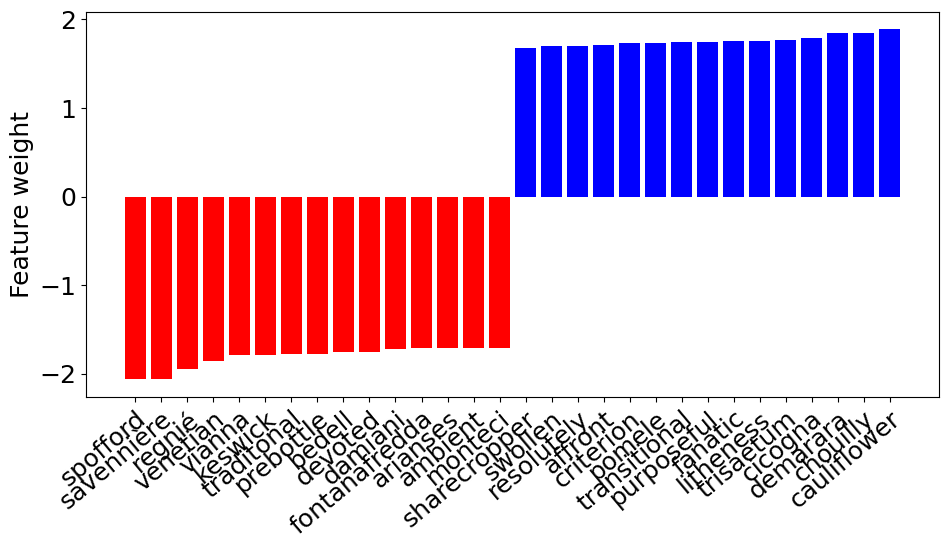

In [18]:
# Some more important features
plot_coefficients(svm, cv.get_feature_names_out(), '', False, 15)

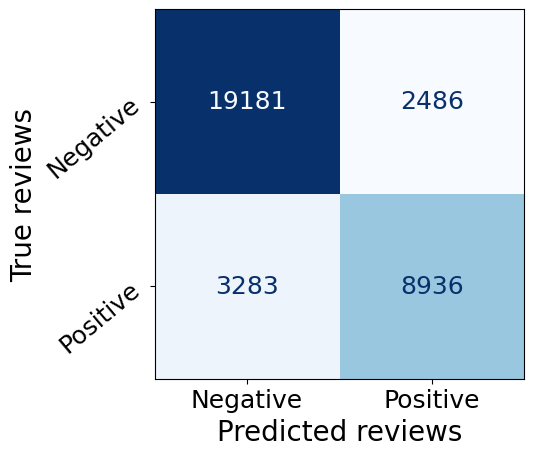

<Figure size 640x480 with 0 Axes>

In [110]:
cm_svm = ConfusionMatrixDisplay.from_estimator(svm, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()
plt.savefig('Graphs/CM_svm_Wine.pdf', format="pdf", bbox_inches="tight")

### Get the NER of the word

Top 5 Positive non-descriptive words:

In [25]:
nlp = spacy.load("en_core_web_lg")
target = 'Chouilly'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        break

# Chouilly GPE
# Cramant and Chouilly ORG

Close to Epernay and on the cusp of the Chardonnay-dominated Côte des Blancs, this producer has Grand Cru holdings in the village of Chouilly. Those vines have produced a wine that balances mineral-laced fruit with a soft aftertaste. Young and with apple flavors, it's great now but will continue to develop in the cellar. Drink from 2018.
Epernay PERSON
Chardonnay ORG
Côte des Blancs ORG
Grand Cru ORG
2018 DATE


In [23]:
nlp = spacy.load("en_core_web_lg")
target = 'demarara'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
# demarara GPE
# demarara syrup ORG

This TBA features almost endless variations on the sugary theme: caramelized sugar, demarara syrup and honey all swirl together, wrapped around a bit of citrusy acidity. A distinctly musky spice note adds interest. Drink now–2040.
demarara GPE
Lush and decadent, with intensely sweet notes of demarara syrup, peach and citrus, yet there's enough acidity to bring you back for another sip, and another. The sugar clings to the palate for a long time on the finish. Drink now–2030.
Lush ORG
decadent DATE
demarara syrup ORG


In [26]:
nlp = spacy.load("en_core_web_lg")
target = 'Cicogna'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
# Cicogna GPE   

You don't see much Syrah from the Veneto in northeast Italy, but Cicogna shows that the variety does have a future here. This expression is soft and plump with ripe fruit, blackberry, leather and tobacco. There's a point of bright freshness on the long finish.
Syrah GPE
Veneto GPE
Italy GPE
Cicogna GPE


In [29]:
nlp = spacy.load("en_core_web_lg")
target = 'Trisaetum'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        break
# Trisaetum ORG  

All Trisaetum's dry Rieslings feel a notch riper in this warm year, to good effect. Meticulous blending of individual lots, some aged in oak, brings layers of complexity and helps differentiate each cuvée. Concentrated pear, peach and papaya flavors are on display here, with tangy acidity and superb length and richness. It's dry, to be sure, but also brilliantly fruity.
Trisaetum ORG
this warm year DATE


Top 5 Negative non-descriptive words

In [34]:
nlp = spacy.load("en_core_web_lg")
target = 'Spofford'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        break

# Spofford Station ORG
# Spofford ORG
# Spofford Station FAC

Though not as powerful and concentrated as the Spofford Station Syrah, this wine displays the same distinctive, complex flavor palette—a mix of earth, herb, compost, fungus, smoke, rock and, oh yeah, baby, oodles of fruit. This sort of flavor profile is similar to the biodynamic wines of Cayuse, but at half the cost.
Spofford Station ORG
Syrah ORG
Cayuse PERSON
half CARDINAL


In [46]:
nlp = spacy.load("en_core_web_lg")
target = 'Savennière'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        break
# Savennières PERSON

Shaped like a butterfly (papillon), this vineyard is one of the best known in Savennières. It is very rich and ripe, from a warm vintage. With its apricot and pear flavors and opulent texture, it brings out the potential of Chenin Blanc. So age this wine for 5–6 years more. Screwcap.
Savennières PERSON
Chenin Blanc PERSON
5–6 years DATE


In [38]:
nlp = spacy.load("en_core_web_lg")
target = 'Regnié'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)

# Regnié PRODUCT

These are definitely old vines, at nearly 100 years of age. The wine from this impeccable producer is juicy with great fruitiness and rich red-cherry flavors. It has fine acidity and light tannins. As befits a wine from Regnié, it is likely to age easily and with fine fruit. Drink from 2017.
nearly 100 years of age DATE
Regnié PRODUCT
2017 DATE


In [39]:
nlp = spacy.load("en_core_web_lg")
target = 'Venetian'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)

# Venetian NORP

A beautiful Venetian villa is surrounded by 200 acres of vineyard and is the setting in which this fine Amarone is crafted. Rhubarb, plum, black cherry exotic spice, espresso and caramel are backed by toast and cedar notes. It has chewy length, refreshing crispness and good power on the finish.
Venetian NORP
200 acres QUANTITY
Rhubarb ORG
“Vecio Belo,” which is Venetian for “old” and “pretty,” bears easy aromas of ripe berry and spice, showing medium intensity and density. There's a soft, velvety feel that gives this a pleasant, easy-going personality.
Vecio Belo PERSON
Venetian NORP
You can see the direction Giuseppe Lonardi wanted to take this 50-50 blend of air-dried Corvina grapes and Cabernet Franc: The goal was to make a bold, modern, super-Venetian wine. Instead, the fruit is a tad too ripe and jammy to be balanced and the wine tastes thick, chewy and slightly tannic on the close.
Giuseppe Lonardi PERSON
50-50 CARDINAL
Corvina ORG
Venetian NORP


In [40]:
nlp = spacy.load("en_core_web_lg")
target = 'Vianna'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)

# Elizabeth Vianna PERSON

A collaboration between Winemakers Elizabeth Vianna (Chimney Rock), Bryan Parker (Terlato Vineyards) and Steve Fennell (Sanford), this is a blend of Sauvignon Blanc from Napa, Chardonnay from Carneros and Viognier from Sta. Rita Hills. Golden in color, it's buttery in style, with subversive fruit that leans lemony crisp and tart on the palate.
Elizabeth Vianna PERSON
Bryan Parker PERSON
Terlato Vineyards PERSON
Steve Fennell PERSON
Sanford PERSON
Sauvignon Blanc LOC
Napa GPE
Carneros PERSON
Viognier PERSON
Sta GPE
Rita Hills GPE


### TD-IDF

In [4]:
tfidf = TfidfVectorizer()
result = tfidf.fit_transform(wineRevs.description)
sorted_terms=sorted(zip(tfidf.get_feature_names_out(),result.toarray().sum(axis=0)),key=lambda x: (x[1], x[0]))
terms = [x[0] for x in sorted_terms]

print(terms[:20]) # low

print(terms[::-1][:20]) # high
# Naj, många high är ju intressanta och beskrivande för reviewn...

['johnstone', 'née', 'monnier', 'organicos', 'vinedos', 'wynn', 'montefiascone', 'servant', 'golan', 'schoenfeld', 'gravitas', 'fieuzal', 'newsletter', 'bienvenida', 'cuteness', 'zoémie', 'lard', 'raytheon', 'services', 'wilkinson']
['wine', 'flavor', 'fruit', 'finish', 'acidity', 'cherry', 'tannin', 'drink', 'aroma', 'palate', 'ripe', 'dry', 'black', 'note', 'spice', 'red', 'rich', 'berry', 'fresh', 'oak']


## Whiskey

In [19]:
# Read
whiskeyRevs = pd.read_csv("Data/Whiskey/scotch_review.csv ", index_col=0)
print(whiskeyRevs.columns)

# Rename
whiskeyRevs = whiskeyRevs[['description', 'review.point']].rename(columns={'review.point' : 'points'})
print(whiskeyRevs.shape)

# Remove duplicates 
whiskeyRevs = whiskeyRevs.drop_duplicates(subset=['description']).reset_index(drop=True)
print('-----')
print(whiskeyRevs.shape)

whiskeyRevs[1:5]

Index(['name', 'category', 'review.point', 'price', 'currency', 'description'], dtype='object')
(2247, 2)
-----
(2245, 2)


,description,points
1,What impresses me most is how this whisky evol...,97
2,There have been some legendary Bowmores from t...,97
3,With a name inspired by a 1926 Buster Keaton m...,96
4,"Captivating, enticing, and wonderfully charmin...",96


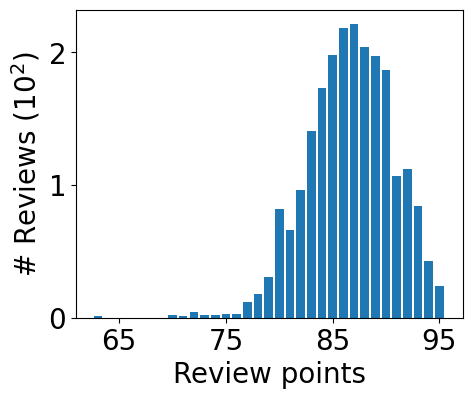

In [13]:
font = {'size'   : 20}
mpl.rc('font', **font) 
fig, ax= plt.subplots(1, 1, figsize=(5,4)) 
ax.hist(whiskeyRevs['points'], width=0.8, bins=(np.arange(63,97)-0.4))
ax.get_yaxis().get_offset_text().set_visible(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_yticks([0, 100, 200])
ax.set_xticks([65, 75, 85, 95])
ax.set_ylabel('# Reviews' + ' ($ 10^{%d}$)' % math.log10(max(ax.get_yticks())))
ax.set_xlabel('Review points')
plt.savefig("Graphs/histPoints_whiskey.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [8]:
print(whiskeyRevs['points'].value_counts().sort_index())

63      1
70      2
71      1
72      4
73      2
74      2
75      3
76      3
77     12
78     18
79     31
80     82
81     66
82     96
83    141
84    173
85    198
86    218
87    221
88    204
89    197
90    187
91    107
92    112
93     84
94     43
95     24
96     10
97      3
Name: points, dtype: int64


In [20]:
nlp = spacy.load("en_core_web_lg")
description = []
for desc in whiskeyRevs['description']:
    doc = nlp(desc) 
    description.append(' '.join([token.lemma_ for token in doc if (not token.is_stop and token.is_alpha)]))
whiskeyRevs['description'] = description

In [21]:
df_whiskey = whiskeyRevs.copy()
points = []
for row in df_whiskey.points:
    if row < 90:
        points.append(0)
    else:
        points.append(1)

df_whiskey['points'] = points

In [22]:
print(df_whiskey['points'].value_counts())

0    1675
1     570
Name: points, dtype: int64


In [23]:
train_x, test_x, train_y, test_y = train_test_split(df_whiskey.description, df_whiskey.points, train_size=0.8, random_state=50)

In [24]:
cv = CountVectorizer()
X_train = cv.fit_transform(train_x)
X_test = cv.transform(test_x)

In [90]:
classifier_naive = MultinomialNB()
classifier_naive.fit(X_train, train_y)
prediction_naive = classifier_naive.predict(X_test)
print(classification_report(test_y, prediction_naive))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       330
           1       0.56      0.38      0.45       119

    accuracy                           0.76       449
   macro avg       0.68      0.63      0.65       449
weighted avg       0.73      0.76      0.74       449



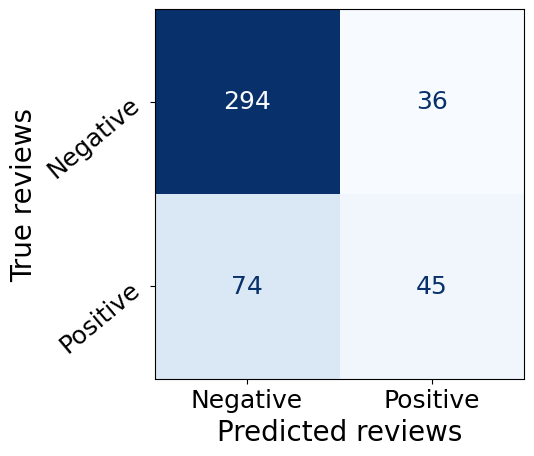

<Figure size 640x480 with 0 Axes>

In [104]:
cm_svm = ConfusionMatrixDisplay.from_estimator(classifier_naive, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()
plt.savefig('Graphs/CM_naive_Whiskey.pdf', format="pdf", bbox_inches="tight")

In [25]:
svm = LinearSVC(dual=False)
svm.fit(X_train, train_y)
prediction_svm = svm.predict(X_test)
print(classification_report(test_y, prediction_svm))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       330
           1       0.50      0.46      0.48       119

    accuracy                           0.74       449
   macro avg       0.66      0.65      0.65       449
weighted avg       0.73      0.74      0.73       449



In [26]:
# Changing ytick-labels

def plot_coefficients(classifier, feature_names, figurename, savePlt=False, top_features=10):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 font = {'size'   : 18}
 mpl.rc('font', **font) 
 fig, ax= plt.subplots(1, 1, figsize=(11,5)) 
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 ax.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 ax.set_yticks([-0.5, 0, 0.5])
 ax.set_xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=40, ha='right', rotation_mode="anchor")
 ax.set_ylabel('Feature weight')
 if savePlt:
    plt.savefig('Graphs/featureImp_' + figurename + '.pdf', format="pdf", bbox_inches="tight")
 plt.show()

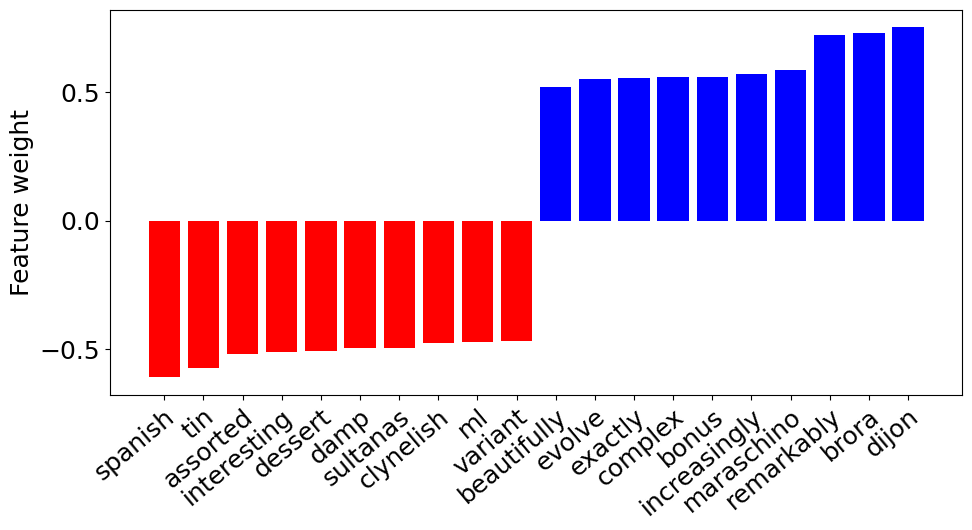

In [27]:
plot_coefficients(svm, cv.get_feature_names_out(), 'Whiskey', True)

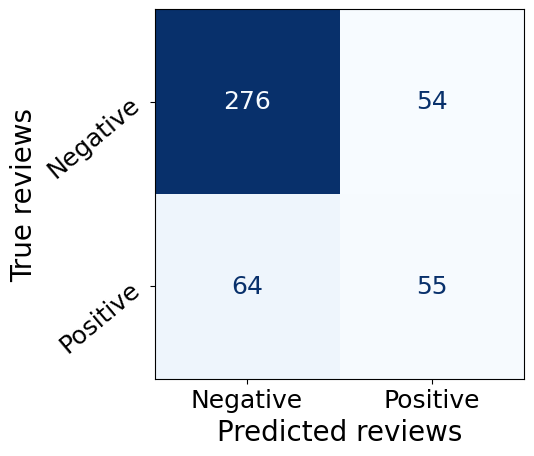

<Figure size 640x480 with 0 Axes>

In [103]:
cm_svm = ConfusionMatrixDisplay.from_estimator(svm, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()
plt.savefig('Graphs/CM_svm_Whiskey.pdf', format="pdf", bbox_inches="tight")

### Get the NER of the word

In [48]:
nlp = spacy.load("en_core_web_lg")
target = 'Spanish'
for desc in whiskeyRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        break
        
# Spanish NORP

A triumphant expression including whisky distilled in 1990, 1992, and 1993 and matured in Spanish oak sherry butts. The nose offers creamy sweet sherry, figs, a hint of black treacle, cinnamon, and ripe cherries. The full palate yields sultanas, tangy citrus fruit, sweet oak, roasted chestnuts, and ginger. Lingering bright fruit notes in the finish, with raisins, plain chocolate, and cigar boxes. (1,487 bottles)
1990 DATE
1992 DATE
1993 DATE
Spanish NORP
1,487 CARDINAL


In [51]:
nlp = spacy.load("en_core_web_lg")
target = 'Brora'
for desc in whiskeyRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        break
        
# Brora PERSON
# Brora ORG
# Previous Broras PERSON
# Classic Brora PERSON
     

Astonishingly fresh and clean for 30 years in oak, and with incredible depth. Slight oily texture. Appetizing brine, with honeyed vanilla, mustard seed, green olive, Seville orange, and lemon zest. Underlying smoke, damp peat, and seaweed. Put simply, Brora at its finest. 

30 years DATE
Seville GPE
Brora ORG


In [57]:
nlp = spacy.load("en_core_web_lg")
target = 'Maraschino'
for desc in whiskeyRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        # break
        
# Maraschino PRODUCT

Maraschino cherries, red currant, oak bark, and wet slate on the nose after 6 months of finishing. Light, clean opening with cherry and strawberry; a little fig and raisin bring depth. Hints of clove and aniseed dart about, then more oak swells up, though the red fruity sweetness stays in control. A smooth finish of fruit chews, with those spices burning brightly deep in the back of the throat. (769 bottles)
Maraschino PRODUCT
6 months DATE
769 CARDINAL


### TF-IDF

In [28]:
tfidf = TfidfVectorizer()
result = tfidf.fit_transform(whiskeyRevs.description)
sorted_terms=sorted(zip(tfidf.get_feature_names_out(),result.toarray().sum(axis=0)),key=lambda x: (x[1], x[0]))
terms = [x[0] for x in sorted_terms]

print(terms[:20]) # low

print(terms[::-1][:20]) # high


['city', 'skeptical', 'superior', 'endeavor', 'lava', 'totally', 'correctly', 'interested', 'maven', 'oth', 'redress', 'rusk', 'spiffe', 'barnacle', 'clutch', 'creature', 'expressiveness', 'fishiness', 'globe', 'lagoon']
['whisky', 'finish', 'note', 'fruit', 'palate', 'oak', 'cask', 'vanilla', 'nose', 'spice', 'sherry', 'dry', 'sweet', 'year', 'old', 'smoke', 'malt', 'chocolate', 'bottle', 'honey']
